# Загружаем необходимые для работы модули

In [2]:
!pip install tpot
!pip install catboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 870.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=b7f5d1adf00468a1151fee0096596c121bb46a93f8db569715ddd7c753ea0b53
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tpot import TPOTRegressor

In [4]:
#функция для преобразования в дату
def to_date(x):
    x = str(x)
    if len(x) == 4:
        x = str(x[0:2])+"-"+str(x[2:])
        x = dt.datetime.strptime(x, '%d-%m')
        return x
    else:
        x = "0"+str(x[0])+"-"+str(x[1:])
        x = dt.datetime.strptime(x, '%d-%m')
        return x

In [6]:
#загрузка датасета
df = pd.read_excel('32_052019_Aleev.xlsx',engine='openpyxl')
df.columns = df.columns.str.strip()

df_steel = df[df['Наименование груза'].str.contains('СТАЛЬ')]
df_steel['Дата прибытия_new'] = df['Дата прибытия'].apply(to_date)
df_steel['Дата отгрузки_new'] = df['Дата отгрузки'].apply(to_date)
df_steel['Длительность доставки'] = (df_steel['Дата прибытия_new'] - df_steel['Дата отгрузки_new']).dt.days
df_steel.drop(columns = ['Дата прибытия', 'Дата отгрузки'], inplace = True)
print(df_steel.shape)
df_steel.head()


<ipython-input-6-6694293cc09f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steel['Дата прибытия_new'] = df['Дата прибытия'].apply(to_date)


(12985, 49)


<ipython-input-6-6694293cc09f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steel['Дата отгрузки_new'] = df['Дата отгрузки'].apply(to_date)
<ipython-input-6-6694293cc09f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steel['Длительность доставки'] = (df_steel['Дата прибытия_new'] - df_steel['Дата отгрузки_new']).dt.days
<ipython-input-6-6694293cc09f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

,Код станции отправления,Станция отправления,Регион отгрузки,Ж.Д отгрузки,Отд. Ж.д отгрузки,Код станции назначения,Станция назначения,Регион поставки,Ж.Д поставки,Отд. Ж.д поставки,...,Код станции назначения загран,Отч мес,Отч год,Код страны отправления,Страна отправления,Код страны назначения,Страна назначения,Дата прибытия_new,Дата отгрузки_new,Длительность доставки
7,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54630,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-02,1900-04-23,9
9,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-03,1900-04-22,11
10,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-09,1900-05-01,8
11,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-10,1900-05-01,9
12,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-11,1900-05-01,10


In [7]:
print(df_steel.shape)

(12985, 49)


In [8]:
print(df_steel.shape)
df = df.drop_duplicates()
print(df_steel.shape)
#дубликатов нет

(12985, 49)
(12985, 49)


In [9]:
missing_values = df_steel.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

E-mail Отправителя              12969
E-mail Получателя               12541
Факс получателя                 10895
ФИО Руководителя получателя      9101
Тел. получателя                  8011
Почтовый индекс получателя       7371
Адрес получателя                 7371
Факс Отправителя                 1009
ФИО Руководителя Отправителя     1005
Тел. Отправителя                  916
Почтовый индекс Отправителя       913
Адрес Отправителя                 913
Отд. Ж.д поставки                 100
Получатель                         64
dtype: int64

Text(0.5, 1.0, 'Пропущенные значения')

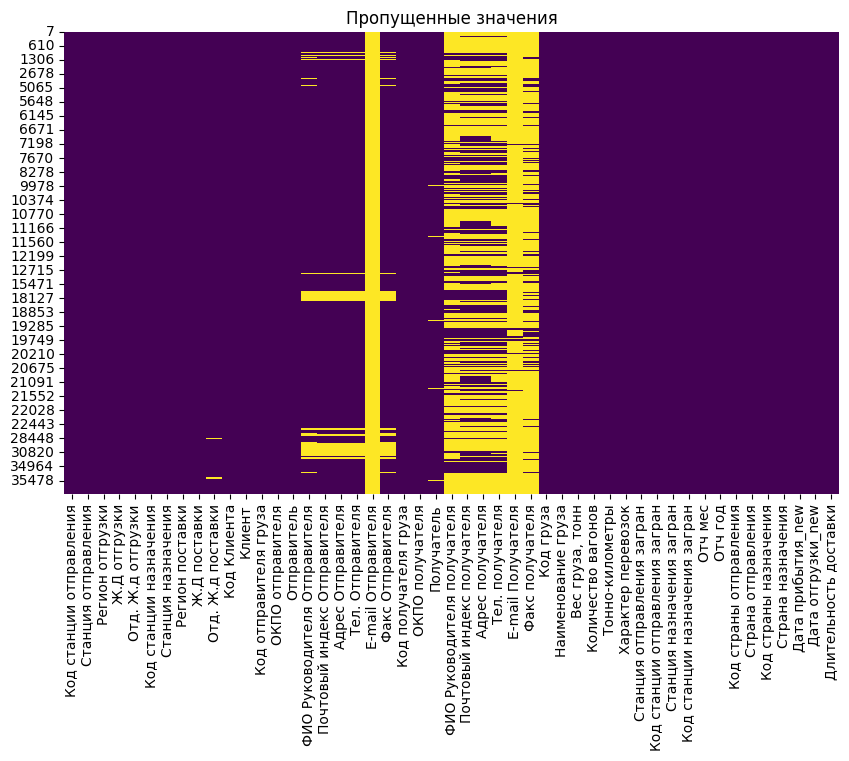

In [10]:
missing_values = df_steel.isnull()
plt.figure(figsize=(10, 6))
sns.heatmap(missing_values, cbar=False, cmap='viridis')
plt.title('Пропущенные значения')

In [11]:
# удаляем столбцы с огромным количеством пропусков
df_steel.drop(columns=[
'ФИО Руководителя Отправителя',
'Почтовый индекс Отправителя',
'Адрес Отправителя',
'Тел. Отправителя',
'E-mail Отправителя',
'Факс Отправителя',
'ФИО Руководителя получателя',
'Почтовый индекс получателя',
'Адрес получателя',
'Тел. получателя',
'E-mail Получателя',
'Факс получателя',
], inplace=True)
# удаляем строки, в которых есть пропуски
df_steel.dropna(inplace=True)
# сбрасываем индексы полсе удаления пропусков
df_steel.reset_index(inplace=True, drop=True)

In [12]:
missing_values = df_steel.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [13]:
df_steel.columns

Index(['Код станции отправления', 'Станция отправления', 'Регион отгрузки',
       'Ж.Д отгрузки', 'Отд. Ж.д отгрузки', 'Код станции назначения',
       'Станция назначения', 'Регион поставки', 'Ж.Д поставки',
       'Отд. Ж.д поставки', 'Код Клиента', 'Клиент', 'Код отправителя груза',
       'ОКПО отправителя', 'Отправитель', 'Код получателя груза',
       'ОКПО получателя', 'Получатель', 'Код груза', 'Наименование груза',
       'Вес груза, тонн', 'Количество вагонов', 'Тонно-километры',
       'Характер перевозок', 'Станция отправления загран',
       'Код станции отправления загран', 'Станция назначения загран',
       'Код станции назначения загран', 'Отч мес', 'Отч год',
       'Код страны отправления', 'Страна отправления', 'Код страны назначения',
       'Страна назначения', 'Дата прибытия_new', 'Дата отгрузки_new',
       'Длительность доставки'],
      dtype='object')

In [14]:
for i in df_steel.columns:
  try:
    print(f'Уникальных значений {i}, {df[i].nunique()}')
  except:
    pass



Уникальных значений Код станции отправления, 649
Уникальных значений Станция отправления, 646
Уникальных значений Регион отгрузки, 68
Уникальных значений Ж.Д отгрузки, 17
Уникальных значений Отд. Ж.д отгрузки, 105
Уникальных значений Код станции назначения, 1197
Уникальных значений Станция назначения, 1195
Уникальных значений Регион поставки, 73
Уникальных значений Ж.Д поставки, 18
Уникальных значений Отд. Ж.д поставки, 109
Уникальных значений Код Клиента, 436
Уникальных значений Клиент, 439
Уникальных значений Код отправителя груза, 546
Уникальных значений ОКПО отправителя, 474
Уникальных значений Отправитель, 468
Уникальных значений Код получателя груза, 2265
Уникальных значений ОКПО получателя, 2144
Уникальных значений Получатель, 2087
Уникальных значений Код груза, 42
Уникальных значений Наименование груза, 42
Уникальных значений Вес груза, тонн, 21015
Уникальных значений Количество вагонов, 80
Уникальных значений Тонно-километры, 32995
Уникальных значений Характер перевозок, 4
Уни

In [15]:
df_steel.head(100)

,Код станции отправления,Станция отправления,Регион отгрузки,Ж.Д отгрузки,Отд. Ж.д отгрузки,Код станции назначения,Станция назначения,Регион поставки,Ж.Д поставки,Отд. Ж.д поставки,...,Код станции назначения загран,Отч мес,Отч год,Код страны отправления,Страна отправления,Код страны назначения,Страна назначения,Дата прибытия_new,Дата отгрузки_new,Длительность доставки
0,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54630,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-02,1900-04-23,9
1,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-03,1900-04-22,11
2,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-09,1900-05-01,8
3,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-10,1900-05-01,9
4,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-11,1900-05-01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30250,ЧЕРЕПОВЕЦ II,ВОЛОГОДСКАЯ ОБЛАСТЬ,Северная,ВОЛОГОДСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-09,1900-04-30,9
96,81760,МАГНИТОГОРСК-ГРУЗОВОЙ,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,Южно-Уральская,КАРТАЛИHСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-13,1900-05-07,6
97,81760,МАГНИТОГОРСК-ГРУЗОВОЙ,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,Южно-Уральская,КАРТАЛИHСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-14,1900-05-07,7
98,81760,МАГНИТОГОРСК-ГРУЗОВОЙ,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,Южно-Уральская,КАРТАЛИHСКОЕ,54490,САМУР-ЭКСПОРТ(В АЗЕРБАЙД),РЕСПУБЛИКА ДАГЕСТАН,Северо-Кавказская,МАХАЧКАЛИH-Е,...,54800,5,19,643,РОССИЯ,31,АЗЕРБАЙДЖАН,1900-05-13,1900-05-08,5


In [50]:
df_steel[['Код отправителя груза','ОКПО отправителя']]

,Код отправителя груза,ОКПО отправителя
0,5010,186217
1,5010,186217
2,5010,186217
3,5010,186217
4,5010,186217
...,...,...
12816,5010,186217
12817,5010,186217
12818,5010,186217
12819,5010,186217


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(0, 0, 'ВОЛОГОДСКАЯ ОБЛАСТЬ'),
  Text(1, 0, 'ЛИПЕЦКАЯ ОБЛАСТЬ'),
  Text(2, 0, 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ'),
  Text(3, 0, 'СВЕРДЛОВСКАЯ ОБЛАСТЬ'),
  Text(4, 0, 'ОРЕНБУРГСКАЯ ОБЛАСТЬ'),
  Text(5, 0, 'РОСТОВСКАЯ ОБЛАСТЬ'),
  Text(6, 0, 'ПРИМОРСКИЙ КРАЙ'),
  Text(7, 0, 'ПЕРМСКАЯ ОБЛАСТЬ'),
  Text(8, 0, 'СМОЛЕНСКАЯ ОБЛАСТЬ'),
  Text(9, 0, 'ЛЕНИНГРАДСКАЯ ОБЛАСТЬ'),
  Text(10, 0, 'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ'),
  Text(11, 0, 'КЕМЕРОВСКАЯ ОБЛАСТЬ'),
  Text(12, 0, 'ТВЕРСКАЯ ОБЛАСТЬ'),
  Text(13, 0, 'ГОРОД САНКТ-ПЕТЕРБУРГ'),
  Text(14, 0, 'НИЖЕГОРОДСКАЯ ОБЛАСТЬ'),
  Text(15, 0, 'ГОРОД МОСКВА СТОЛИЦА РФ'),
  Text(16, 0, 'МОСКОВСКАЯ ОБЛАСТЬ'),
  Text(17, 0, 'ИРКУТСКАЯ ОБЛАСТЬ'),
  Text(18, 0, 'КИРОВСКАЯ ОБЛАСТЬ'),
  Text(19, 0, 'САМАРСКАЯ ОБЛАСТЬ'),
  Text(20, 0, 'БЕЛГОРОДСКАЯ ОБЛАСТЬ'),
  Text(21, 0, 'ТУЛЬСКАЯ ОБЛАСТЬ'),
  Text(22, 0, 'ЧИТИНСКАЯ ОБЛАСТЬ'),
  Text

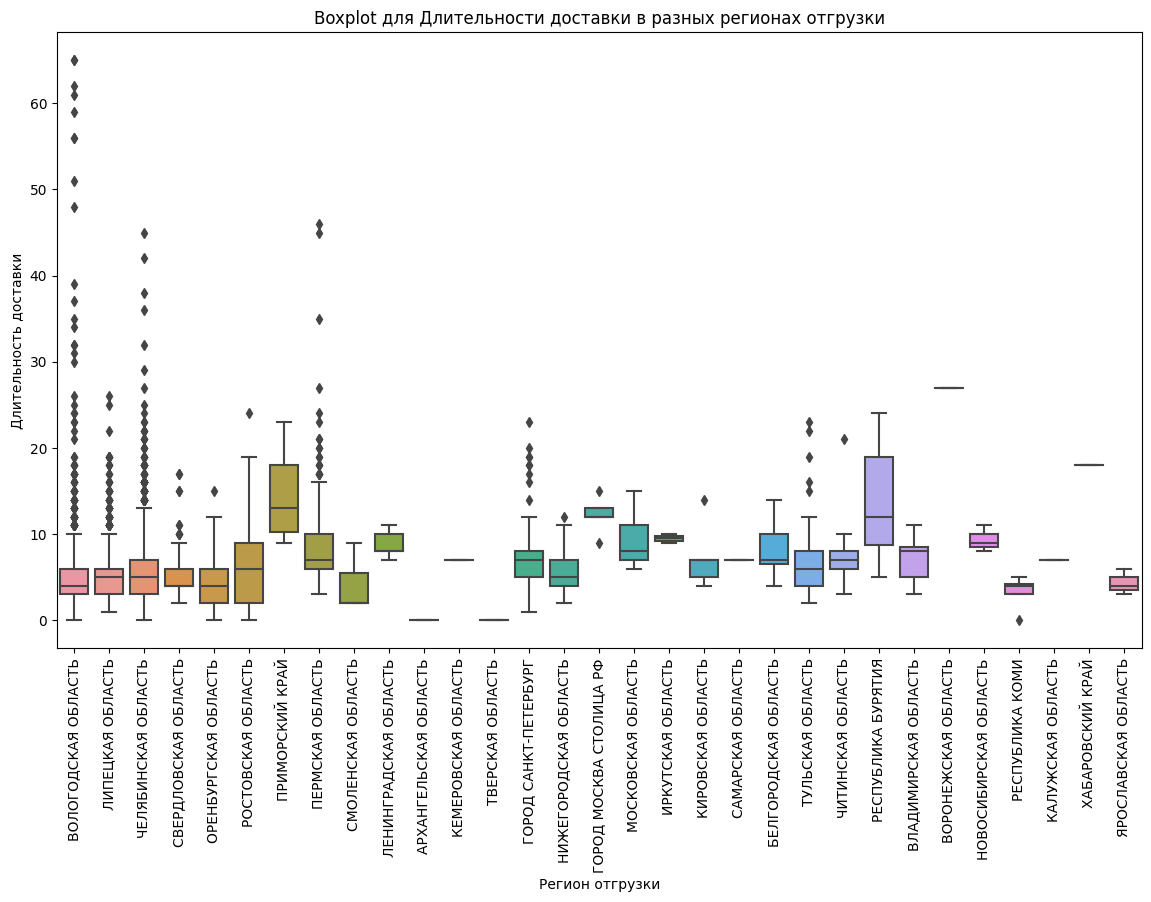

In [16]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Регион отгрузки', y='Длительность доставки', data=df_steel)
plt.title('Boxplot для Длительности доставки в разных регионах отгрузки')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Scatter plot для Веса груза и Количество вагонов')

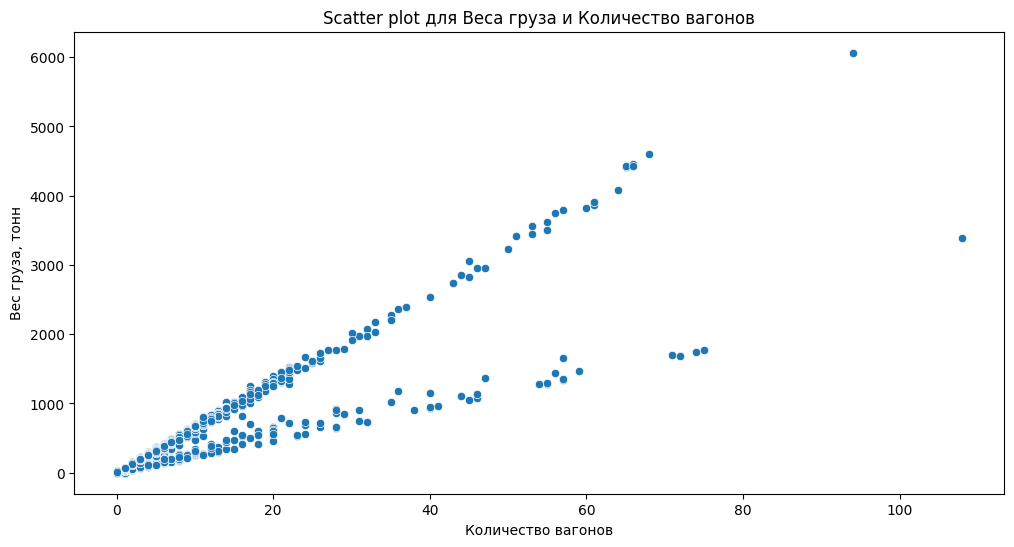

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Количество вагонов', y='Вес груза, тонн', data=df_steel)
plt.title('Scatter plot для Веса груза и Количество вагонов')

Text(0.5, 1.0, 'Scatter plot для Веса груза и Количество вагонов')

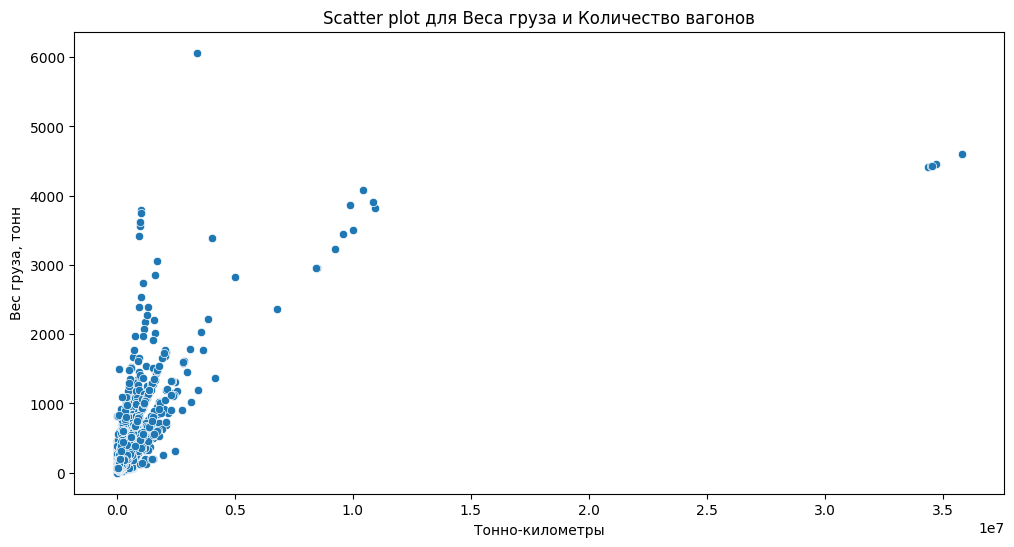

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Тонно-километры', y='Вес груза, тонн', data=df_steel)
plt.title('Scatter plot для Веса груза и Количество вагонов')

Среднее значение  5.263317993916231
Медина  5.0
Мода  0    3
Name: Длительность доставки, dtype: int64


Text(0.5, 1.0, 'Гистограмма для Длительности доставки')

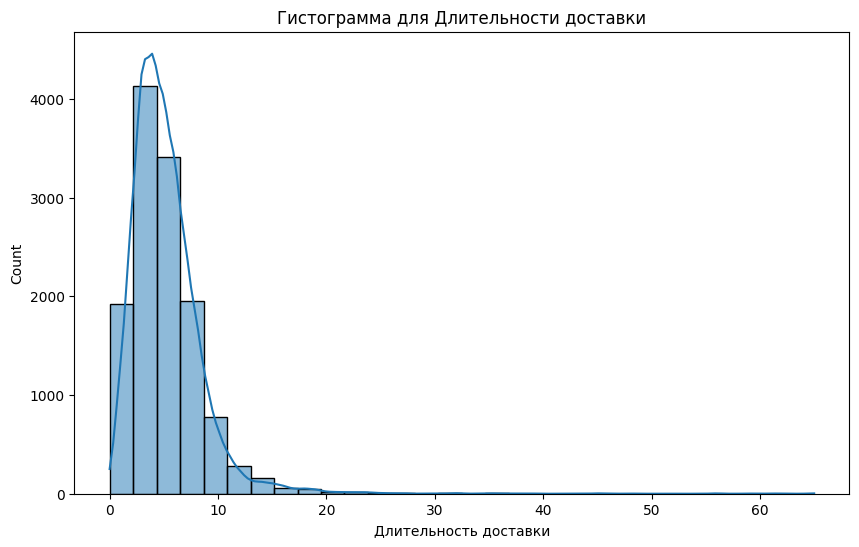

In [19]:
print("Среднее значение ",df_steel['Длительность доставки'].mean())
print("Медина ",df_steel['Длительность доставки'].median())
print("Мода ",df_steel['Длительность доставки'].mode())
plt.figure(figsize=(10, 6))
sns.histplot(df_steel['Длительность доставки'], bins=30, kde=True)
plt.title('Гистограмма для Длительности доставки')


Внутр. пер    10506
Экспорт        2248
Импорт           64
Транзит           3
Name: Характер перевозок, dtype: int64


Text(0.5, 1.0, 'Count plot для Характера перевозок')

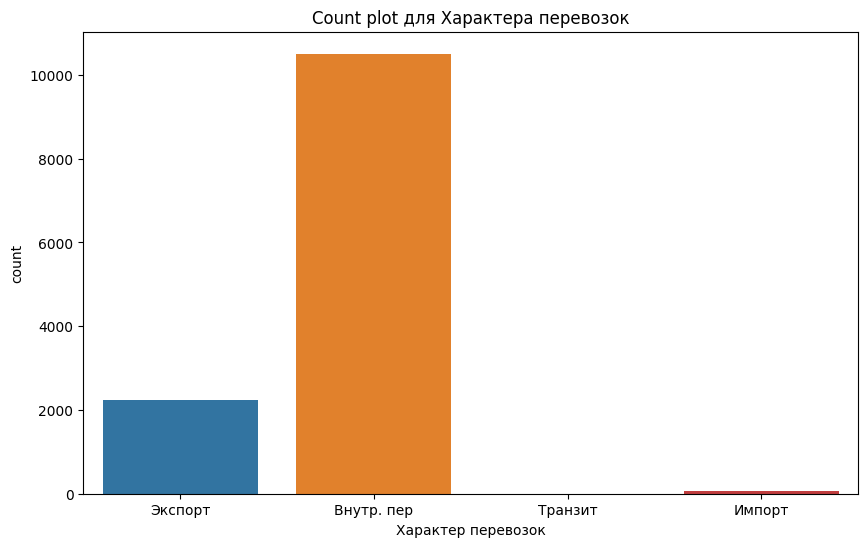

In [20]:
print(df_steel['Характер перевозок'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='Характер перевозок', data=df_steel)
plt.title('Count plot для Характера перевозок')

<Axes: xlabel='Отч мес', ylabel='count'>

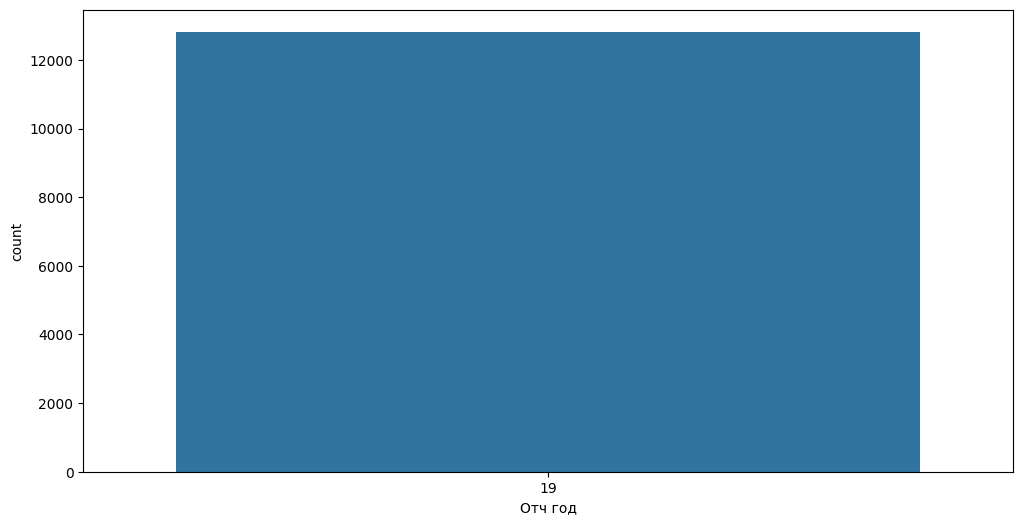

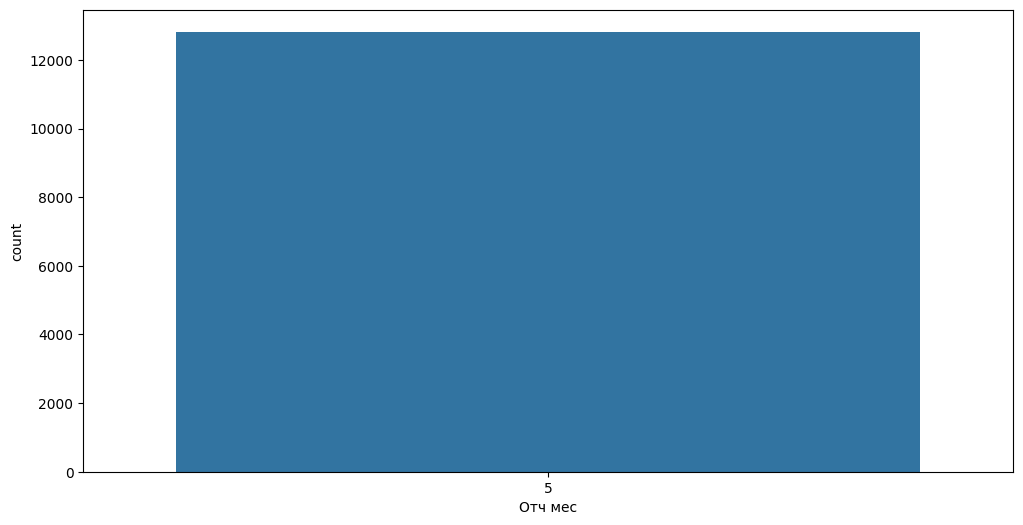

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Отч год', data=df_steel)
plt.figure(figsize=(12, 6))
sns.countplot(x='Отч мес', data=df_steel)


In [22]:
df_steel['Отч год'].value_counts().count()

1

In [23]:
df_steel['Отч мес'].value_counts().count()

1

In [24]:
df_steel.drop(columns = ['Отч год',
                         'Отч мес'], inplace=True)

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_steel.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Матрица корреляции')

<ipython-input-25-0b68ed05a8ef>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_steel.corr(), annot=True, cmap='coolwarm', linewidths=.5)


Text(0.5, 1.0, 'Матрица корреляции')

In [26]:
df_steel[['Дата прибытия_new','Дата отгрузки_new','Длительность доставки']]

,Дата прибытия_new,Дата отгрузки_new,Длительность доставки
0,1900-05-02,1900-04-23,9
1,1900-05-03,1900-04-22,11
2,1900-05-09,1900-05-01,8
3,1900-05-10,1900-05-01,9
4,1900-05-11,1900-05-01,10
...,...,...,...
12816,1900-05-08,1900-04-30,8
12817,1900-05-02,1900-04-29,3
12818,1900-05-02,1900-04-23,9
12819,1900-05-02,1900-05-01,1


In [27]:
df_steel[['Вес груза, тонн','Количество вагонов', 'Длительность доставки']].describe()

,"Вес груза, тонн",Количество вагонов,Длительность доставки
count,12821.000000,12821.000000,12821.000000
mean,143.386123,2.418298,5.263318
std,241.716892,4.529361,3.512836
min,0.000000,0.000000,0.000000
25%,64.765000,1.000000,3.000000
50%,67.900000,1.000000,5.000000
75%,133.500000,2.000000,7.000000
max,6064.050000,108.000000,65.000000


In [28]:
df_steel['Длительность доставки'].nunique()

48

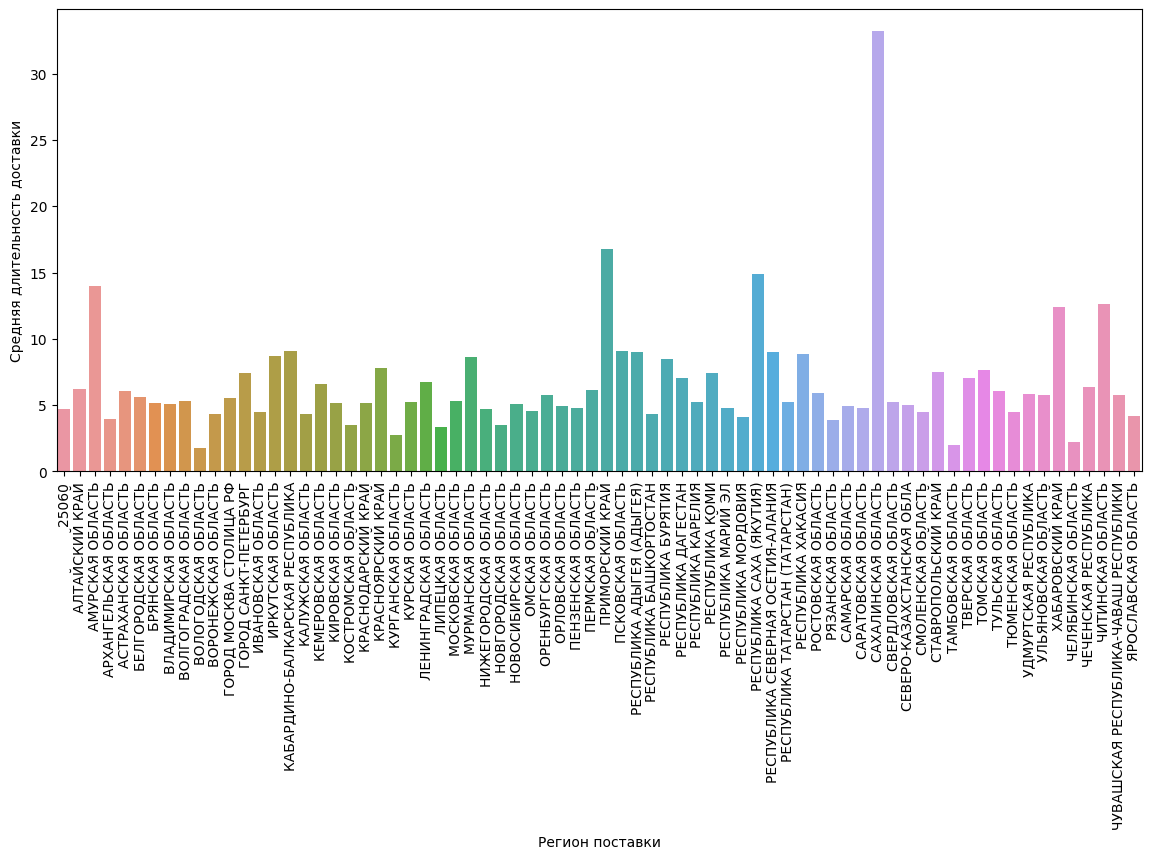

In [29]:
x = df_steel.groupby(by='Регион поставки')['Длительность доставки'].mean()
data = x.reset_index()
fig = plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
bars=sns.barplot(data=data, x='Регион поставки', y='Длительность доставки')
bars.set(ylabel='Средняя длительность доставки')

[Text(0, 0.5, 'Средняя длительность доставки')]

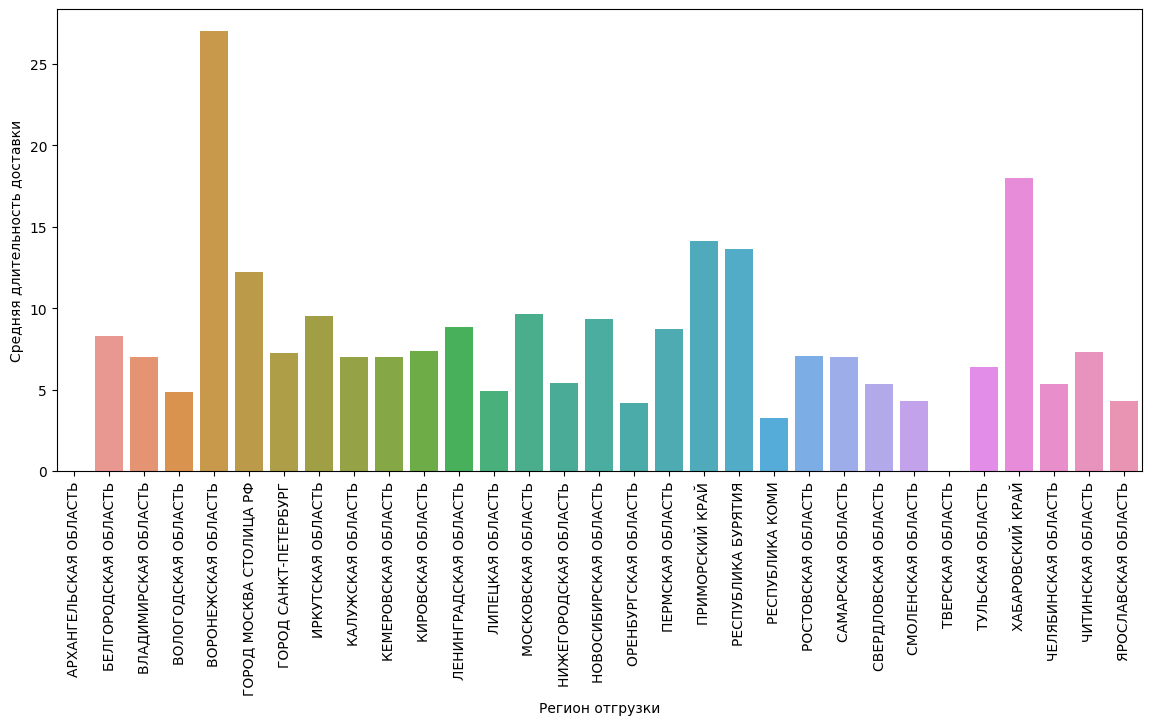

In [87]:
x = df_steel.groupby(by='Регион отгрузки')['Длительность доставки'].mean()
data = x.reset_index()
fig = plt.figure(figsize=(14, 6))
plt.xticks(rotation=90)
bars=sns.barplot(data=data, x='Регион отгрузки', y='Длительность доставки')
bars.set(ylabel='Средняя длительность доставки')

Text(0, 0.5, 'Длительность доставки')

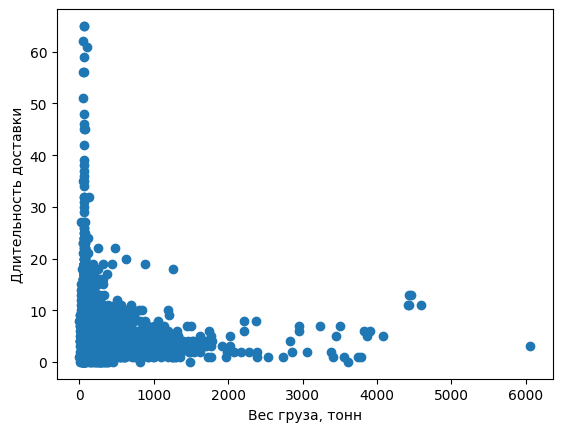

In [88]:
plt.scatter(df_steel['Вес груза, тонн'], df_steel['Длительность доставки'])
plt.xlabel('Вес груза, тонн')
plt.ylabel('Длительность доставки')

<Axes: xlabel='Характер перевозок', ylabel='Длительность доставки'>

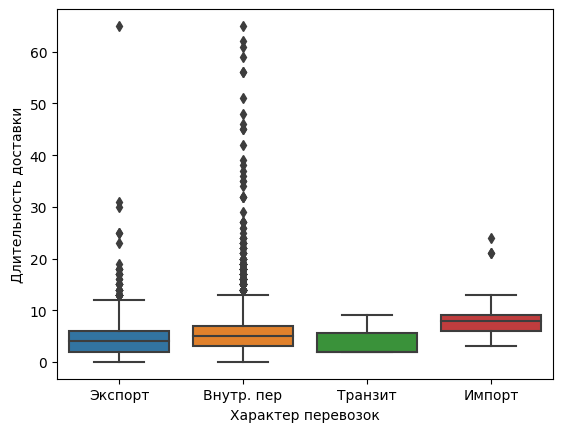

In [89]:
sns.boxplot(x='Характер перевозок', y='Длительность доставки', data=df_steel)

In [90]:
df_steel.columns

Index(['Код станции отправления', 'Станция отправления', 'Регион отгрузки',
       'Ж.Д отгрузки', 'Отд. Ж.д отгрузки', 'Код станции назначения',
       'Станция назначения', 'Регион поставки', 'Ж.Д поставки',
       'Отд. Ж.д поставки', 'Код Клиента', 'Клиент', 'Код отправителя груза',
       'ОКПО отправителя', 'Отправитель', 'Код получателя груза',
       'ОКПО получателя', 'Получатель', 'Код груза', 'Наименование груза',
       'Вес груза, тонн', 'Количество вагонов', 'Тонно-километры',
       'Характер перевозок', 'Станция отправления загран',
       'Код станции отправления загран', 'Станция назначения загран',
       'Код станции назначения загран', 'Код страны отправления',
       'Страна отправления', 'Код страны назначения', 'Страна назначения',
       'Дата прибытия_new', 'Дата отгрузки_new', 'Длительность доставки'],
      dtype='object')

In [91]:
df_steel.describe()

,Код станции отправления,Код станции назначения,Код Клиента,Код отправителя груза,ОКПО отправителя,Код получателя груза,ОКПО получателя,Код груза,"Вес груза, тонн",Количество вагонов,Тонно-километры,Код станции отправления загран,Код станции назначения загран,Код страны отправления,Код страны назначения,Длительность доставки
count,12821.000000,12821.000000,1.282100e+04,12821.000000,1.282100e+04,12821.000000,1.282100e+04,12821.000000,12821.000000,12821.000000,1.282100e+04,12821.00000,12821.000000,12821.000000,12821.000000,12821.000000
mean,60802.602761,47573.003666,1.032581e+09,5547.812963,3.733010e+06,4883.151626,3.781380e+07,32416.183995,143.386123,2.418298,1.839693e+05,11053.68146,8071.163716,114.321816,83.752749,5.263318
std,22517.834190,27971.151499,3.217825e+08,1396.044254,1.011479e+07,2564.631137,3.265605e+07,0.884383,241.716892,4.529361,7.718640e+05,25281.64027,20695.299819,245.302093,219.557423,3.512836
min,3080.000000,1630.000000,1.000006e+09,863.000000,0.000000e+00,25.000000,0.000000e+00,32415.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,30250.000000,22420.000000,1.000232e+09,5010.000000,1.862170e+05,2895.000000,3.104295e+06,32416.000000,64.765000,1.000000,5.151500e+04,0.00000,0.000000,0.000000,0.000000,3.000000
50%,59220.000000,52100.000000,1.000236e+09,5010.000000,1.864240e+05,4683.000000,3.714478e+07,32416.000000,67.900000,1.000000,1.031450e+05,0.00000,0.000000,0.000000,0.000000,5.000000
75%,81760.000000,78030.000000,1.001351e+09,7363.000000,5.757665e+06,6623.000000,6.576929e+07,32416.000000,133.500000,2.000000,1.660330e+05,0.00000,0.000000,0.000000,0.000000,7.000000
max,98830.000000,99810.000000,7.000091e+09,9999.000000,9.927221e+07,9999.000000,9.996920e+07,32419.000000,6064.050000,108.000000,3.580672e+07,98190.00000,98190.000000,804.000000,860.000000,65.000000


In [93]:
df_steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821 entries, 0 to 12820
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Код станции отправления         12821 non-null  int64         
 1   Станция отправления             12821 non-null  object        
 2   Регион отгрузки                 12821 non-null  object        
 3   Ж.Д отгрузки                    12821 non-null  object        
 4   Отд. Ж.д отгрузки               12821 non-null  object        
 5   Код станции назначения          12821 non-null  int64         
 6   Станция назначения              12821 non-null  object        
 7   Регион поставки                 12821 non-null  object        
 8   Ж.Д поставки                    12821 non-null  object        
 9   Отд. Ж.д поставки               12821 non-null  object        
 10  Код Клиента                     12821 non-null  int64         
 11  Кл

In [30]:
df_steel.drop(columns=['Станция отправления', 'Станция назначения', 'Клиент',
            'Отправитель','Получатель','Регион отгрузки', 'Регион поставки','Наименование груза',
            'Дата прибытия_new','Дата отгрузки_new', 'Станция отправления загран',
             'Станция назначения загран', 'Страна отправления', 'Страна назначения',
             'Ж.Д отгрузки', 'Ж.Д поставки'
], inplace=True)

In [31]:
df_steel.columns

Index(['Код станции отправления', 'Отд. Ж.д отгрузки',
       'Код станции назначения', 'Отд. Ж.д поставки', 'Код Клиента',
       'Код отправителя груза', 'ОКПО отправителя', 'Код получателя груза',
       'ОКПО получателя', 'Код груза', 'Вес груза, тонн', 'Количество вагонов',
       'Тонно-километры', 'Характер перевозок',
       'Код станции отправления загран', 'Код станции назначения загран',
       'Код страны отправления', 'Код страны назначения',
       'Длительность доставки'],
      dtype='object')

In [32]:
df_steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821 entries, 0 to 12820
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Код станции отправления         12821 non-null  int64  
 1   Отд. Ж.д отгрузки               12821 non-null  object 
 2   Код станции назначения          12821 non-null  int64  
 3   Отд. Ж.д поставки               12821 non-null  object 
 4   Код Клиента                     12821 non-null  int64  
 5   Код отправителя груза           12821 non-null  int64  
 6   ОКПО отправителя                12821 non-null  int64  
 7   Код получателя груза            12821 non-null  int64  
 8   ОКПО получателя                 12821 non-null  int64  
 9   Код груза                       12821 non-null  int64  
 10  Вес груза, тонн                 12821 non-null  float64
 11  Количество вагонов              12821 non-null  int64  
 12  Тонно-километры                 

In [33]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [34]:
df_steel.head()

,Код станции отправления,Отд. Ж.д отгрузки,Код станции назначения,Отд. Ж.д поставки,Код Клиента,Код отправителя груза,ОКПО отправителя,Код получателя груза,ОКПО получателя,Код груза,"Вес груза, тонн",Количество вагонов,Тонно-километры,Характер перевозок,Код станции отправления загран,Код станции назначения загран,Код страны отправления,Код страны назначения,Длительность доставки
0,30250,ВОЛОГОДСКОЕ,54490,МАХАЧКАЛИH-Е,1000231777,5010,186217,548,0,32415,58.510,1,161371,Экспорт,30250,54630,643,31,9
1,30250,ВОЛОГОДСКОЕ,54490,МАХАЧКАЛИH-Е,1000231777,5010,186217,9940,0,32415,50.510,1,151025,Экспорт,30250,54800,643,31,11
2,30250,ВОЛОГОДСКОЕ,54490,МАХАЧКАЛИH-Е,1000231777,5010,186217,9999,0,32419,118.094,2,325703,Экспорт,30250,54800,643,31,8
3,30250,ВОЛОГОДСКОЕ,54490,МАХАЧКАЛИH-Е,1000231777,5010,186217,9999,0,32419,58.457,1,161224,Экспорт,30250,54800,643,31,9
4,30250,ВОЛОГОДСКОЕ,54490,МАХАЧКАЛИH-Е,1000231777,5010,186217,9999,0,32415,62.584,1,172607,Экспорт,30250,54800,643,31,10


In [35]:
df_steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821 entries, 0 to 12820
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Код станции отправления         12821 non-null  int64  
 1   Отд. Ж.д отгрузки               12821 non-null  object 
 2   Код станции назначения          12821 non-null  int64  
 3   Отд. Ж.д поставки               12821 non-null  object 
 4   Код Клиента                     12821 non-null  int64  
 5   Код отправителя груза           12821 non-null  int64  
 6   ОКПО отправителя                12821 non-null  int64  
 7   Код получателя груза            12821 non-null  int64  
 8   ОКПО получателя                 12821 non-null  int64  
 9   Код груза                       12821 non-null  int64  
 10  Вес груза, тонн                 12821 non-null  float64
 11  Количество вагонов              12821 non-null  int64  
 12  Тонно-километры                 

In [36]:
print(df_steel.shape)
df_steel.drop_duplicates()
df_steel.shape

(12821, 19)


(12821, 19)

In [37]:

label_encoder = LabelEncoder()
for col in ['Отд. Ж.д отгрузки', 'Отд. Ж.д поставки', 'Характер перевозок']:
    df_steel[col] = label_encoder.fit_transform(df_steel[col])

# Создаем экземпляр StandardScaler
scaler = StandardScaler()

# Производим нормализацию данных
normalized_data = scaler.fit_transform(df_steel)

X = df_steel.drop('Длительность доставки', axis=1)
y = df_steel['Длительность доставки']



In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Проверяем формы данных
print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_test:", y_test.shape)

Форма X_train: (10256, 18)
Форма X_test: (2565, 18)
Форма y_train: (10256,)
Форма y_test: (2565,)


In [40]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, r2_score


my_model_gradient_boosting = GradientBoostingRegressor(n_estimators=50, random_state=42)

my_model_gradient_boosting.fit(X_train, y_train)


y_pred = my_model_gradient_boosting.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Model: {my_model_gradient_boosting}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')

Model: GradientBoostingRegressor(n_estimators=50, random_state=42)
Mean Squared Error: 6.750
Mean Absolute Error: 1.442
R2: 0.455
RMSE: 2.598


In [122]:
tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring = 'neg_mean_absolute_error' )
tpot.fit(X_train, y_train)

#Оценка модели
print(tpot.score(X_test, y_test))

#Экспорт обученной модели
tpot.export('tpot_regressor_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.3192995252507145

Generation 2 - Current best internal CV score: -1.3192995252507145

Generation 3 - Current best internal CV score: -1.2697536115859598

Generation 4 - Current best internal CV score: -1.2604583928930224

Generation 5 - Current best internal CV score: -1.2552565983446493

Best pipeline: ExtraTreesRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.8, min_samples_leaf=6, min_samples_split=9, n_estimators=100)
-1.2282669957498846


In [41]:
from sklearn.ensemble import ExtraTreesRegressor
import joblib
trot = ExtraTreesRegressor( bootstrap=False, max_features=0.8, min_samples_leaf=6, min_samples_split=9, n_estimators=100)
trot.fit(X_train, y_train)


y_pred = trot.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Model: {trot}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')

Model: ExtraTreesRegressor(max_features=0.8, min_samples_leaf=6, min_samples_split=9)
Mean Squared Error: 5.332
Mean Absolute Error: 1.226
R2: 0.569
RMSE: 2.309


In [78]:
joblib.dump(trot, 'extra_trees_model.pkl')

['extra_trees_model.pkl']

0:	learn: 2.1671304	total: 58.8ms	remaining: 35.2s
1:	learn: 2.1012581	total: 70.3ms	remaining: 21s
2:	learn: 2.0356822	total: 74.7ms	remaining: 14.9s
3:	learn: 1.9782395	total: 78.4ms	remaining: 11.7s
4:	learn: 1.9206504	total: 88.4ms	remaining: 10.5s
5:	learn: 1.8770377	total: 93.9ms	remaining: 9.3s
6:	learn: 1.8409645	total: 115ms	remaining: 9.76s
7:	learn: 1.8013811	total: 124ms	remaining: 9.14s
8:	learn: 1.7720069	total: 134ms	remaining: 8.79s
9:	learn: 1.7377782	total: 147ms	remaining: 8.65s
10:	learn: 1.7118867	total: 158ms	remaining: 8.46s
11:	learn: 1.6865646	total: 172ms	remaining: 8.44s
12:	learn: 1.6672396	total: 196ms	remaining: 8.84s
13:	learn: 1.6503406	total: 201ms	remaining: 8.41s
14:	learn: 1.6290036	total: 209ms	remaining: 8.14s
15:	learn: 1.6134919	total: 221ms	remaining: 8.05s
16:	learn: 1.5941798	total: 228ms	remaining: 7.83s
17:	learn: 1.5811327	total: 240ms	remaining: 7.77s
18:	learn: 1.5658800	total: 259ms	remaining: 7.93s
19:	learn: 1.5530970	total: 269ms	rema

Text(0.5, 1.0, 'Feature Importance in CatBoost')

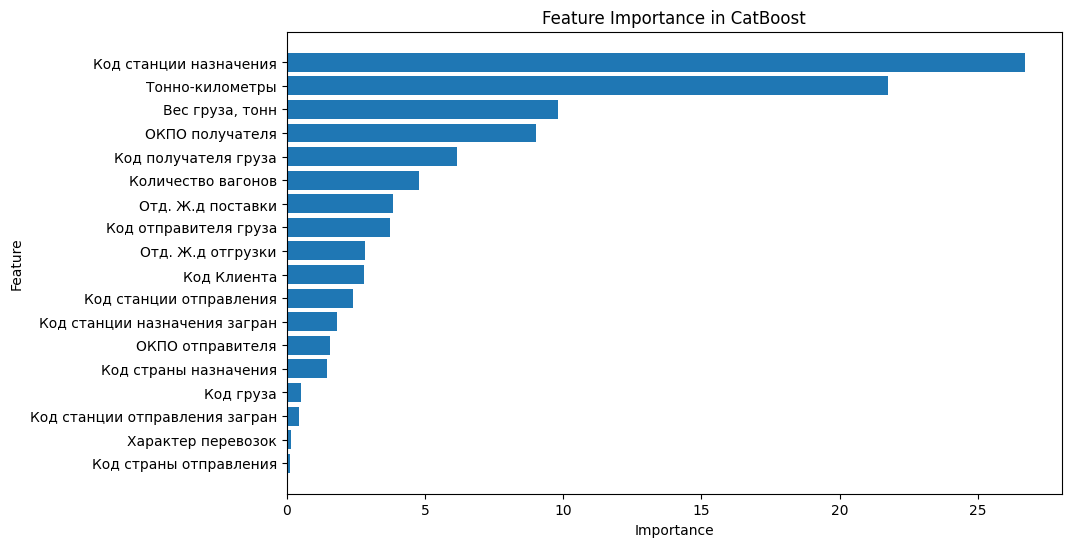

In [42]:
from catboost import CatBoostRegressor
first_CatBoostRegressor = CatBoostRegressor(loss_function='MAE', iterations=600, learning_rate=0.11, depth=5)

first_CatBoostRegressor.fit(X_train, y_train)
y_pred = first_CatBoostRegressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Model: {first_CatBoostRegressor}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
# Получение важности фич
feature_importance =first_CatBoostRegressor.feature_importances_

# Создание DataFrame для удобства визуализации
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Сортировка по важности в убывающем порядке
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Визуализация важности фич
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost')

In [128]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

# Создаем экземпляр модели CatBoostRegressor
catboost_model = CatBoostRegressor()

# Задаем сетку параметров для перебора
param_grid = {
    'iterations': [500, 600, 700],
    'learning_rate': [0.1, 0.11, 0.12],
    'depth': [4, 5, 6],
    'l2_leaf_reg': [1, 3, 5]
}

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=2)

# Запускаем поиск по сетке
grid_search.fit(X_train, y_train)

# Выводим наилучшие параметры
print("Наилучшие параметры:", grid_search.best_params_)

# Получаем предсказания с наилучшей моделью
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Выводим MAE
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Model: {best_model}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')


Выходные данные были обрезаны до нескольких последних строк (5000).
613:	learn: 1.5697535	total: 1.7s	remaining: 238ms
614:	learn: 1.5696645	total: 1.71s	remaining: 236ms
615:	learn: 1.5689730	total: 1.71s	remaining: 233ms
616:	learn: 1.5683260	total: 1.71s	remaining: 230ms
617:	learn: 1.5682462	total: 1.71s	remaining: 228ms
618:	learn: 1.5675928	total: 1.72s	remaining: 225ms
619:	learn: 1.5668259	total: 1.72s	remaining: 222ms
620:	learn: 1.5667505	total: 1.72s	remaining: 219ms
621:	learn: 1.5659154	total: 1.73s	remaining: 216ms
622:	learn: 1.5657273	total: 1.73s	remaining: 214ms
623:	learn: 1.5654589	total: 1.73s	remaining: 211ms
624:	learn: 1.5651472	total: 1.73s	remaining: 208ms
625:	learn: 1.5645058	total: 1.74s	remaining: 205ms
626:	learn: 1.5636775	total: 1.74s	remaining: 202ms
627:	learn: 1.5633328	total: 1.74s	remaining: 200ms
628:	learn: 1.5628705	total: 1.74s	remaining: 197ms
629:	learn: 1.5625194	total: 1.75s	remaining: 194ms
630:	learn: 1.5620493	total: 1.75s	remaining: 191

In [43]:
from catboost import CatBoostRegressor
my_model = CatBoostRegressor(loss_function='MAE', depth=6, iterations=700, l2_leaf_reg=5, learning_rate=0.11)

my_model.fit(X_train, y_train, verbose=100)
y_pred = my_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'Model: {my_model}')
print(f'Mean Squared Error: {mse:.3f}')
print(f'Mean Absolute Error: {mae:.3f}')
print(f'R2: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')

0:	learn: 2.1710773	total: 6.06ms	remaining: 4.24s
100:	learn: 1.2370583	total: 424ms	remaining: 2.52s
200:	learn: 1.1590517	total: 871ms	remaining: 2.16s
300:	learn: 1.1135335	total: 1.31s	remaining: 1.73s
400:	learn: 1.0914131	total: 1.75s	remaining: 1.31s
500:	learn: 1.0760510	total: 2.17s	remaining: 864ms
600:	learn: 1.0553238	total: 2.61s	remaining: 430ms
699:	learn: 1.0449120	total: 3.03s	remaining: 0us
Model: <catboost.core.CatBoostRegressor object at 0x789e0bd336d0>
Mean Squared Error: 6.397
Mean Absolute Error: 1.171
R2: 0.483
RMSE: 2.529


In [81]:
joblib.dump(my_model, 'catboost_model.pkl')

['catboost_model.pkl']

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100, 1000]
}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_


param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100, 1000]
}
grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_absolute_error')
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_


param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_absolute_error')
grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_




models = [
    ('Random Forest', best_rf),
    ('Ridge Regression', best_ridge),
    ('Lasso Regression', best_lasso),
    ('Gradient Boosting', best_gb)
]

for model_name, model in models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Model: {model_name}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.3f}')
    print('--------------------------')


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Model: Random Forest
Mean Squared Error: 4.23
Mean Absolute Error: 1.34
RMSE: 2.06
--------------------------
Model: Ridge Regression
Mean Squared Error: 7.15
Mean Absolute Error: 1.65
RMSE: 2.67
--------------------------
Model: Lasso Regression
Mean Squared Error: 9.62
Mean Absolute Error: 2.07
RMSE: 3.10
--------------------------
Model: Gradient Boosting
Mean Squared Error: 3.85
Mean Absolute Error: 1.25
RMSE: 1.96
--------------------------


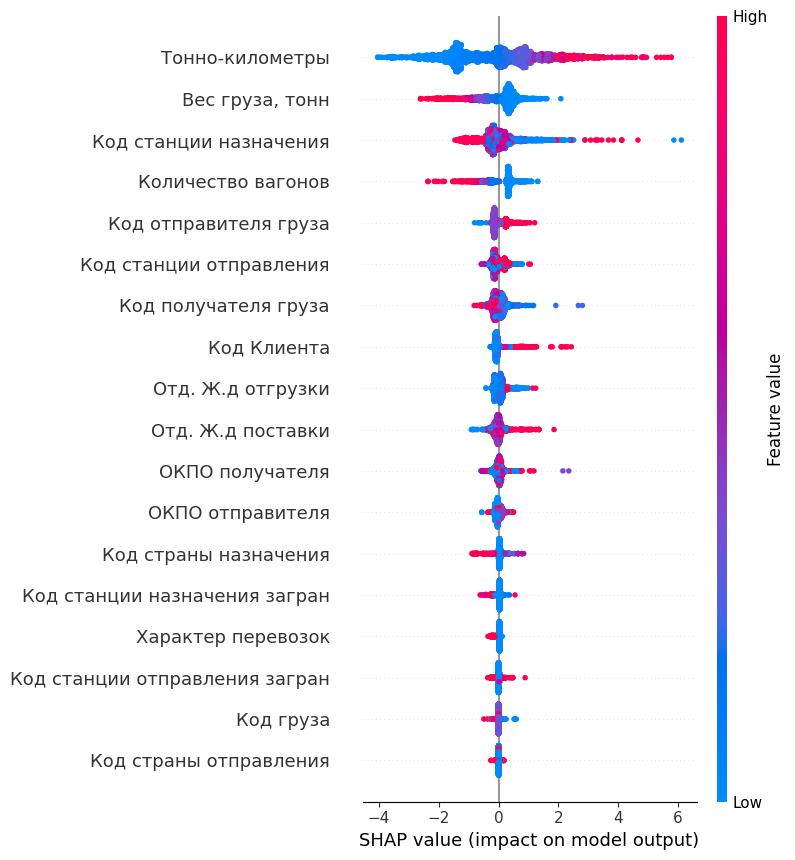

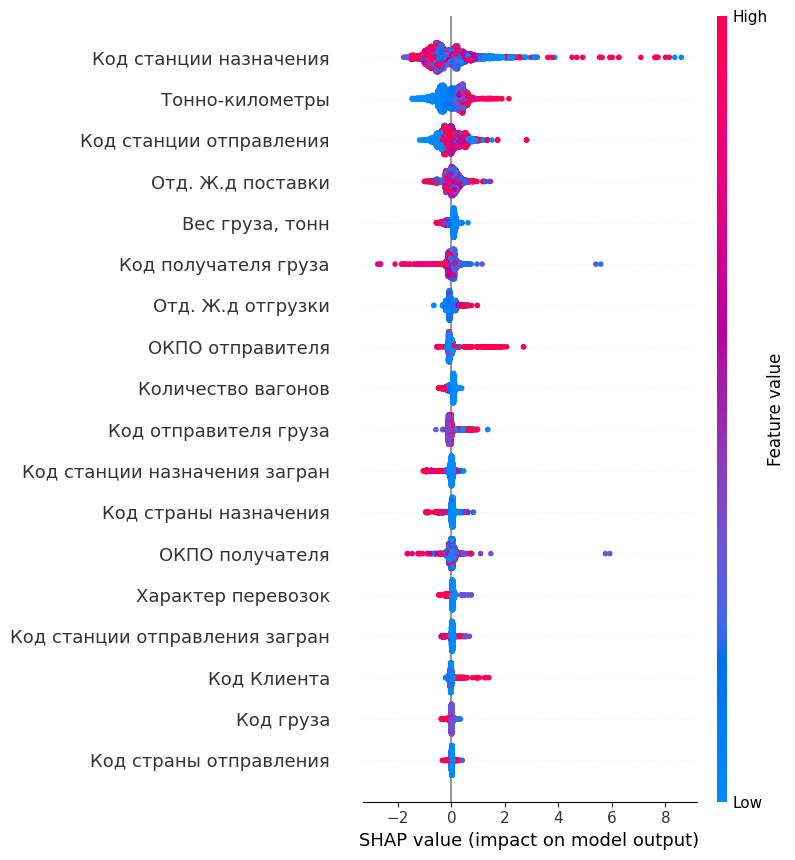

In [44]:
import shap

explainer_cat = shap.TreeExplainer(my_model)
shap_values_cat = explainer_cat.shap_values(X_test)
explainer_trot = shap.TreeExplainer(trot)
shap_values_trot = explainer_trot.shap_values(X_test)
# Визуализация SHAP summary_plot
shap.summary_plot(shap_values_cat, X_test)
shap.summary_plot(shap_values_trot, X_test)


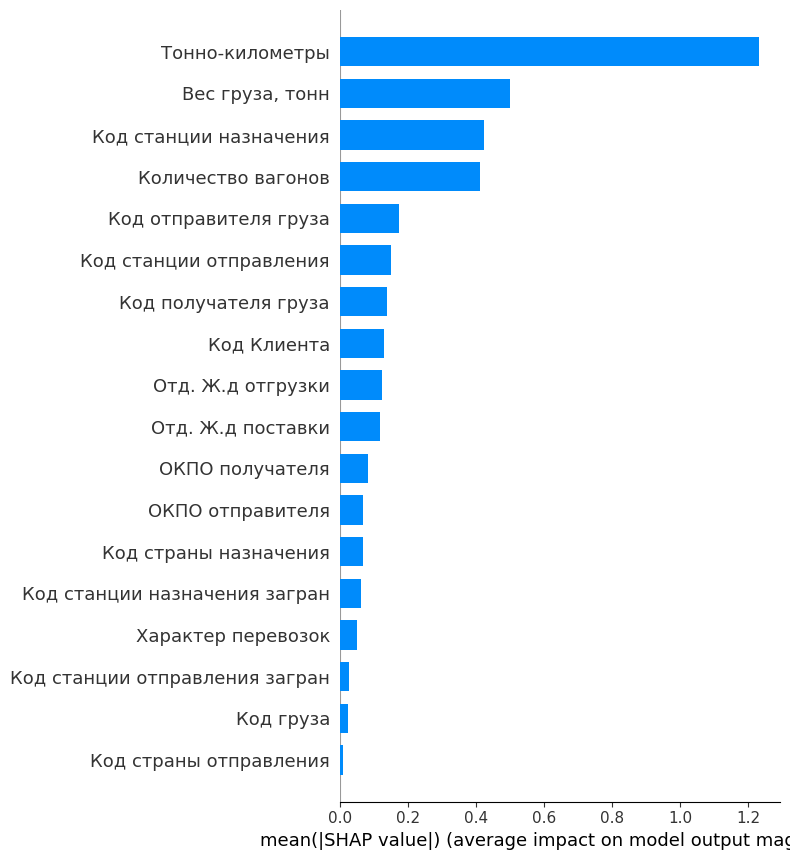

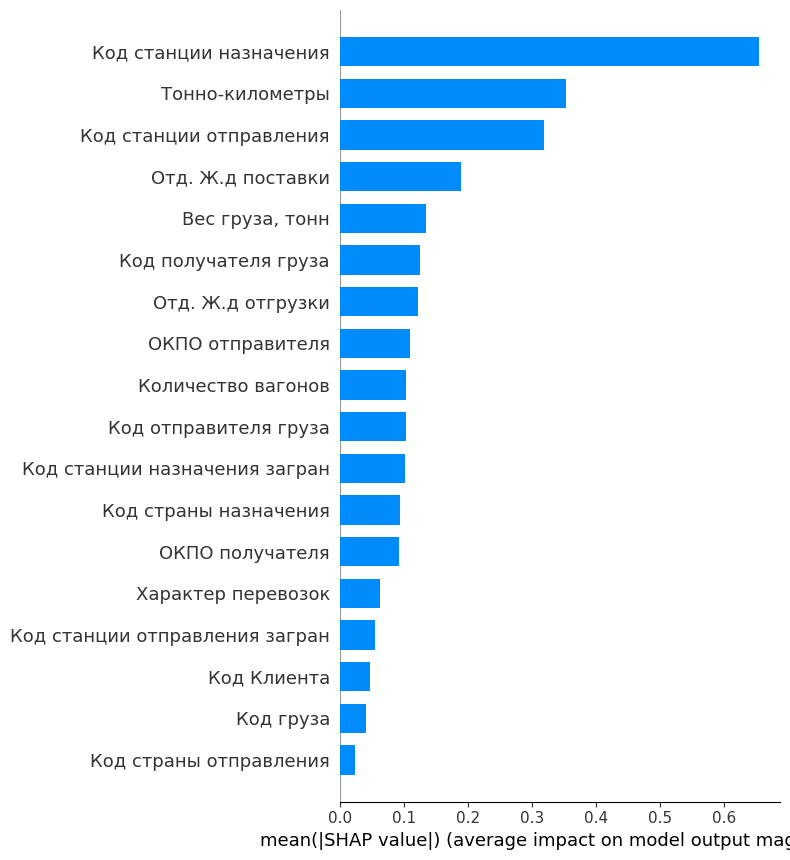

In [45]:
# График для нашей модели
shap.summary_plot(shap_values_cat, X_test, plot_type="bar")

shap.summary_plot(shap_values_trot, X_test, plot_type="bar")

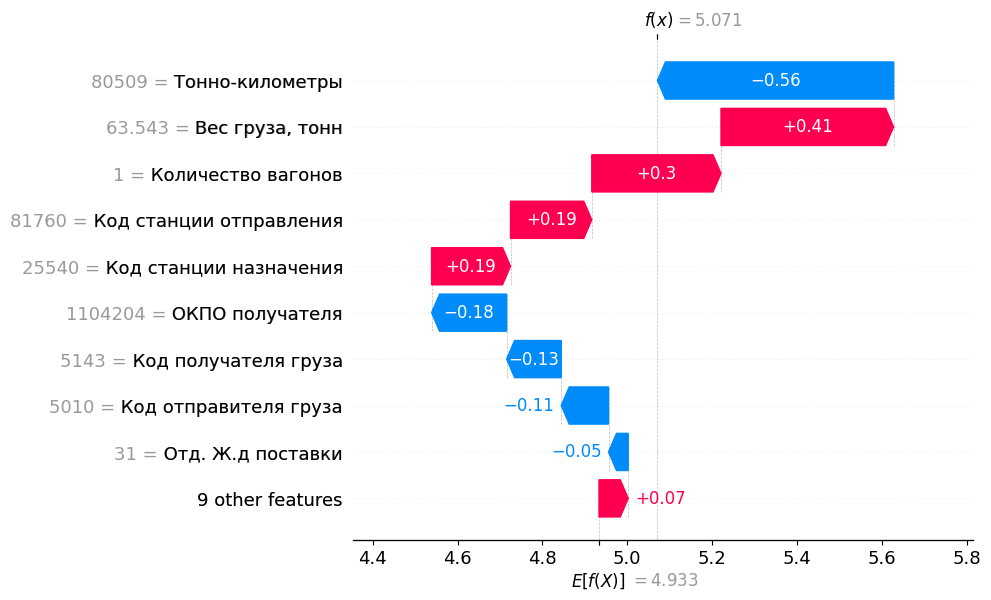

In [46]:
explainer = explainer_cat
shap_values = shap_values_cat

# Выбираем индекс объекта, для которого хотим построить водопад
index_to_plot = df_steel.index[df_steel['Длительность доставки'] == 3].tolist()[1]

# Получаем значения SHAP для конкретного объекта
shap_values_obj = shap_values[index_to_plot]

# Получаем Explanation объект
shap_explanation = shap.Explanation(values=shap_values_obj, base_values=explainer.expected_value, data=X_test.iloc[index_to_plot])

# Передаем Explanation объект для построения водопада
shap.waterfall_plot(shap_explanation)

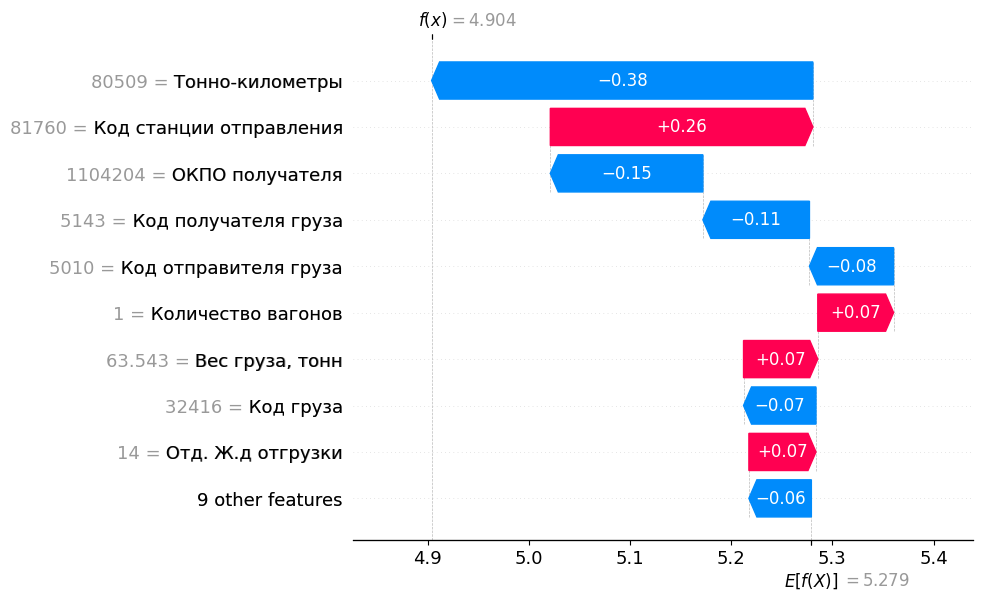

In [47]:
explainer = explainer_trot
shap_values = shap_values_trot

# Выбираем индекс объекта, для которого хотим построить водопад
index_to_plot = df_steel.index[df_steel['Длительность доставки'] == 3].tolist()[1]

# Получаем значения SHAP для конкретного объекта
shap_values_obj = shap_values[index_to_plot]

# Получаем Explanation объект
shap_explanation = shap.Explanation(values=shap_values_obj, base_values=explainer.expected_value, data=X_test.iloc[index_to_plot])

# Передаем Explanation объект для построения водопада
shap.waterfall_plot(shap_explanation)

In [80]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=e1db96a16c0470cf7310a8ece63ab9731f57b677328b38628a78891c52a296fd
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [48]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Функция для построения улучшенной модели
def build_improved_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=512, step=64),
                    input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(BatchNormalization())

    # Добавление скрытых слоев с регуляризацией Dropout
    for i in range(hp.Int('num_layers', min_value=2, max_value=8)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(BatchNormalization())

    model.add(Dense(1, activation='linear'))

    # Планирование скорости обучения
    initial_learning_rate = hp.Choice('initial_learning_rate', values=[1e-3, 5e-4, 1e-4])
    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

tuner = RandomSearch(
    build_improved_model,
    objective='val_loss',
    max_trials=15,
    directory='my_dir',
    project_name='my_project'
)

# Поиск оптимальных параметров
tuner.search(X_train_scaled, y_train, epochs=150, validation_data=(X_test_scaled, y_test))

# Получение лучших гиперпараметров
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Создание и обучение окончательной модели с лучшими гиперпараметрами
final_model = tuner.hypermodel.build(best_hp)
final_model.fit(X_train_scaled, y_train, epochs=250, batch_size=64, validation_data=(X_test_scaled, y_test))

y_pred = final_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Среднеквадратичная ошибка: {mse:.2f}')
print(f'Средняя абсолютная ошибка: {mae:.2f}')
print(f'Корень из среднеквадратичной ошибки: {rmse:.2f}')

Trial 15 Complete [00h 09m 26s]
val_loss: 9.41938304901123

Best val_loss So Far: 4.307188034057617
Total elapsed time: 01h 59m 28s
Epoch 1/250
161/161 [==============================] - 3s 8ms/step - loss: 34.7953 - mae: 4.9197 - val_loss: 29.8407 - val_mae: 4.7024
Epoch 2/250
161/161 [==============================] - 1s 8ms/step - loss: 23.8218 - mae: 3.8818 - val_loss: 18.3436 - val_mae: 3.4475
Epoch 3/250
161/161 [==============================] - 1s 6ms/step - loss: 13.9454 - mae: 2.5623 - val_loss: 12.2678 - val_mae: 2.1901
Epoch 4/250
161/161 [==============================] - 1s 6ms/step - loss: 9.9374 - mae: 1.9536 - val_loss: 7.6418 - val_mae: 1.5611
Epoch 5/250
161/161 [==============================] - 1s 6ms/step - loss: 9.0557 - mae: 1.8476 - val_loss: 7.4437 - val_mae: 1.4918
Epoch 6/250
161/161 [==============================] - 1s 6ms/step - loss: 8.6308 - mae: 1.7860 - val_loss: 7.7776 - val_mae: 1.4821
Epoch 7/250
161/161 [==============================] - 1s 5ms/st

In [51]:
joblib.dump(my_model, 'neir.pkl')

['neir.pkl']

In [ ]:
import shap

explainer_cat = shap.TreeExplainer(my_model)
shap_values_cat = explainer_cat.shap_values(X_test)

# Визуализация SHAP summary_plot
shap.summary_plot(shap_values_cat, X_test)